# ARIMA & SARIMAX models for Time-Series Forecasting
---
**Author:** Tigran Khachatryan

## Introduction <a name="introduction"></a>
---
Before even looking at the data, it's important to define what general insights we are interested in.
The dataset is coming from a delivery company so we can roughly outline the business model of a food delivery company.

For this analysis we will assume that delivery companies get its revenue from two main sources:
1) Up to 30% per cent cut from every order.
2) Delivery fees.

The first revenue stream depends on the volume of orders and the value of each order.
While the second depends on multiple variables including delivery distance, order size, order value, day of the week etc.

This distinction already shows two distinct areas for analysis each corresponding to the revenue stream mentioned above.

1) Time series analysis of sales data.
2) Spatial analysis and delivery fee estimates.

If we are capable of generating insights in any of these categories then these insights will probably be of interest for the underlying delivery company.

Let's look at the available data and see what aspects are well covered by the provided dataset.

## Exploratory Data Analysis <a name="eda"></a>
---
Let's import the necessary modules and load the datatest.

In [1]:
# Standard Library
import itertools
import warnings
from datetime import datetime, timedelta

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns
%matplotlib inline

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [2]:
source_df = pd.read_csv('data/orders.csv')
df = source_df.copy()
df.sample(5)

TIMESTAMP  \
9905   2020-09-04 09:34:00.000   
8295   2020-08-29 10:47:00.000   
10218  2020-09-05 08:09:00.000   
201    2020-08-01 15:58:00.000   
5929   2020-08-21 17:28:00.000   

       ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  ITEM_COUNT  \
9905                                                   2              5   
8295                                                   7              1   
10218                                                 -3              1   
201                                                   -2              5   
5929                                                  17              1   

       USER_LAT  USER_LONG  VENUE_LAT  VENUE_LONG  ESTIMATED_DELIVERY_MINUTES  \
9905     60.189     24.951     60.172      24.958                          39   
8295     60.200     24.969     60.192      24.952                          28   
10218    60.161     24.935     60.162      24.940                          25   
201      60.193     24.942     60.180      24.949                          34   
5929     60.159     24.944     60.168      24.939                          36   

       ACTUAL_DELIVERY_MINUTES  CLOUD_COVERAGE  TEMPERATURE  WIND_SPEED  \
9905                        41             0.0         15.6    5.138720   
8295                        35             0.0         16.7    3.065180   
10218                       22            45.0         15.0    5.656740   
201                         32             0.0         19.4    0.750587   
5929                        53             0.0         20.6    2.480370   

       PRECIPITATION  
9905             0.0  
8295             0.0  
10218            0.0  
201              0.0  
5929             0.0

### Variables  <a name="variables"></a>
---
Brief description of the variables:

| Variable                   | Type       |           | Units   | Description                                                                |
|----------------------------|------------|-----------|---------|----------------------------------------------------------------------------|
| TIMESTAMP                  | Continuous | Numerical | minutes | Time when the order was placed. Eastern European Standard Time GMT+2       |
| ITEM_COUNT                 | Discrete   | Numerical | items   | Number of items in the order.                                              |
| USER_LAT                   | Continuous | Numerical | degrees | Coordinates (truncated to 3 decimal places, coordinate system unspecified) |
| USER_LONG                  | Continuous | Numerical | degrees | Coordinates (truncated to 3 decimal places, coordinate system unspecified) |
| VENUE_LAT                  | Continuous | Numerical | degrees | Coordinates (truncated to 3 decimal places, coordinate system unspecified) |
| VENUE_LONG                 | Continuous | Numerical | degrees | Coordinates (truncated to 3 decimal places, coordinate system unspecified) |
| ESTIMATED_DELIVERY_MINUTES | Continuous | Numerical | minutes | Estimated delivery duration. (Estimation method unknown)                   |
| ACTUAL_DELIVERY_MINUTES    | Continuous | Numerical | minutes | Order delivery duration.                                                   |
| ACTUAL - ESTIMATED         | Continuous | Numerical | minutes | Actual - Estimated delivery duration.                                      |
| CLOUD_COVERAGE             | Continuous | Numerical | %       | The fraction of the sky obscured by clouds.                                |
| TEMPERATURE                | Continuous | Numerical | °C      | Air temperature at a particular location                                   |
| WIND_SPEED                 | Continuous | Numerical | m/s     | Wind speed at a particular location                                        |
| PRECIPITATION              | Continuous | Numerical | mm      | Atmospheric water vapour under gravitational pull                          |
|                            |            |           |         |                                                                            |


In [3]:
df.describe()

ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES    ITEM_COUNT  \
count                                       18706.000000     18706.000000   
mean                                           -1.201058         2.688228   
std                                             8.979834         1.886455   
min                                           -41.000000         1.000000   
25%                                            -7.000000         1.000000   
50%                                            -2.000000         2.000000   
75%                                             5.000000         4.000000   
max                                            34.000000        11.000000   

           USER_LAT     USER_LONG     VENUE_LAT    VENUE_LONG  \
count  18706.000000  18706.000000  18706.000000  18706.000000   
mean      60.175234     24.941244     60.175643     24.941214   
std        0.012674      0.016540      0.011509      0.014482   
min       60.153000     24.909000     60.149000     24.878000   
25%       60.163000     24.926000     60.167000     24.930000   
50%       60.175000     24.943000     60.170000     24.941000   
75%       60.186000     24.954000     60.186000     24.950000   
max       60.201000     24.980000     60.219000     25.042000   

       ESTIMATED_DELIVERY_MINUTES  ACTUAL_DELIVERY_MINUTES  CLOUD_COVERAGE  \
count                18706.000000             18706.000000    18429.000000   
mean                    33.809313                32.608254       11.996853   
std                      7.340283                10.018879       23.812605   
min                     10.000000                 6.000000        0.000000   
25%                     28.000000                25.000000        0.000000   
50%                     33.000000                32.000000        0.000000   
75%                     38.000000                40.000000       25.000000   
max                     82.000000                58.000000      100.000000   

        TEMPERATURE    WIND_SPEED  PRECIPITATION  
count  18429.000000  18429.000000   18706.000000  
mean      16.973536      3.790991       0.332756  
std        3.411900      1.456017       1.129234  
min        6.100000      0.077419       0.000000  
25%       14.400000      2.696190       0.000000  
50%       16.700000      3.631970       0.000000  
75%       18.900000      4.692530       0.000000  
max       26.700000      9.857300       6.315790

At a first glance we can see that there are no extreme deviations between mean and median values of each column. This suggests that we can expect little skewness in the distributions. But that has to be examined more in detail later.

In [4]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18706 entries, 0 to 18705
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   TIMESTAMP                                             18706 non-null  datetime64[ns]
 1   ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  18706 non-null  int64         
 2   ITEM_COUNT                                            18706 non-null  int64         
 3   USER_LAT                                              18706 non-null  float64       
 4   USER_LONG                                             18706 non-null  float64       
 5   VENUE_LAT                                             18706 non-null  float64       
 6   VENUE_LONG                                            18706 non-null  float64       
 7   ESTIMATED_DELIVERY_MINUTES                            18706 non-null  int64 

We can see that environmental data has some NaN values. 
We would probably need to drop these values if we decide to use these variables. Otherwise, the other variables and dtypes seem to be in order.

## Correlations <a name="corrs"></a>
---
Now that we have some understanding of the variables we can look at the relationships between them.

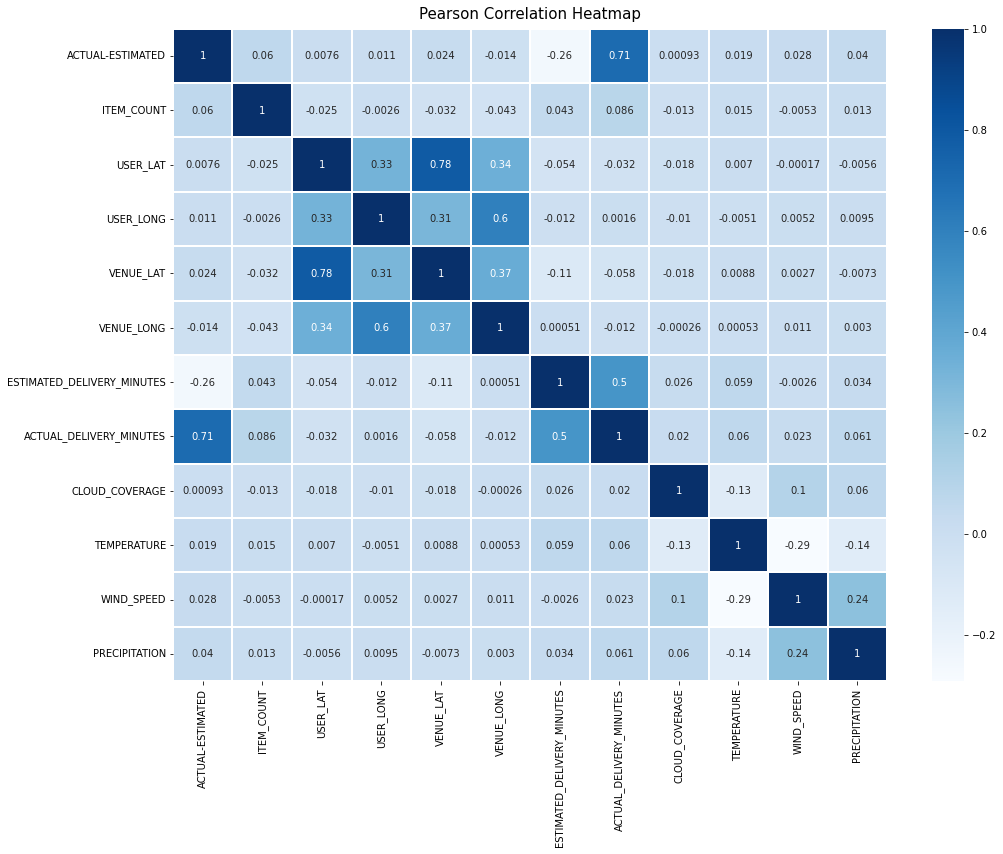

In [5]:
def correlation_check(df: pd.DataFrame) -> None:
    """
    Plots a Pearson Correlation Heatmap.
    ---
    Args:
        df (pd.DataFrame): dataframe to plot
        
    Returns: None
    """
    
    # Pretty Name
    df.rename(columns={"ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES": "ACTUAL-ESTIMATED"},
              inplace=True)
    
    # Figure
    fig, ax = plt.subplots(figsize=(16,12), facecolor='w')
    correlations_df = df.corr(method='pearson', min_periods=1)
    sns.heatmap(correlations_df, cmap="Blues", annot=True, linewidth=.1)

    # Labels
    ax.set_title("Pearson Correlation Heatmap", fontsize=15, pad=10)
    ax.set_facecolor(color='white')

correlation_check(df)

### Observations
- At a first glance, it seems that there are no immediately apparent relationships between the variables.
- ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES is strongly correlated with ACTUAL_DELIVERY_MINUTES and ESTIMATED_DELIVERY_MINUTES but that doesn't give us new or useful information.
- There are correlations between coordinates. Not a very useful relationship to explore either.

We can take a more detailed look at correlations and distributions to see if we find something there.

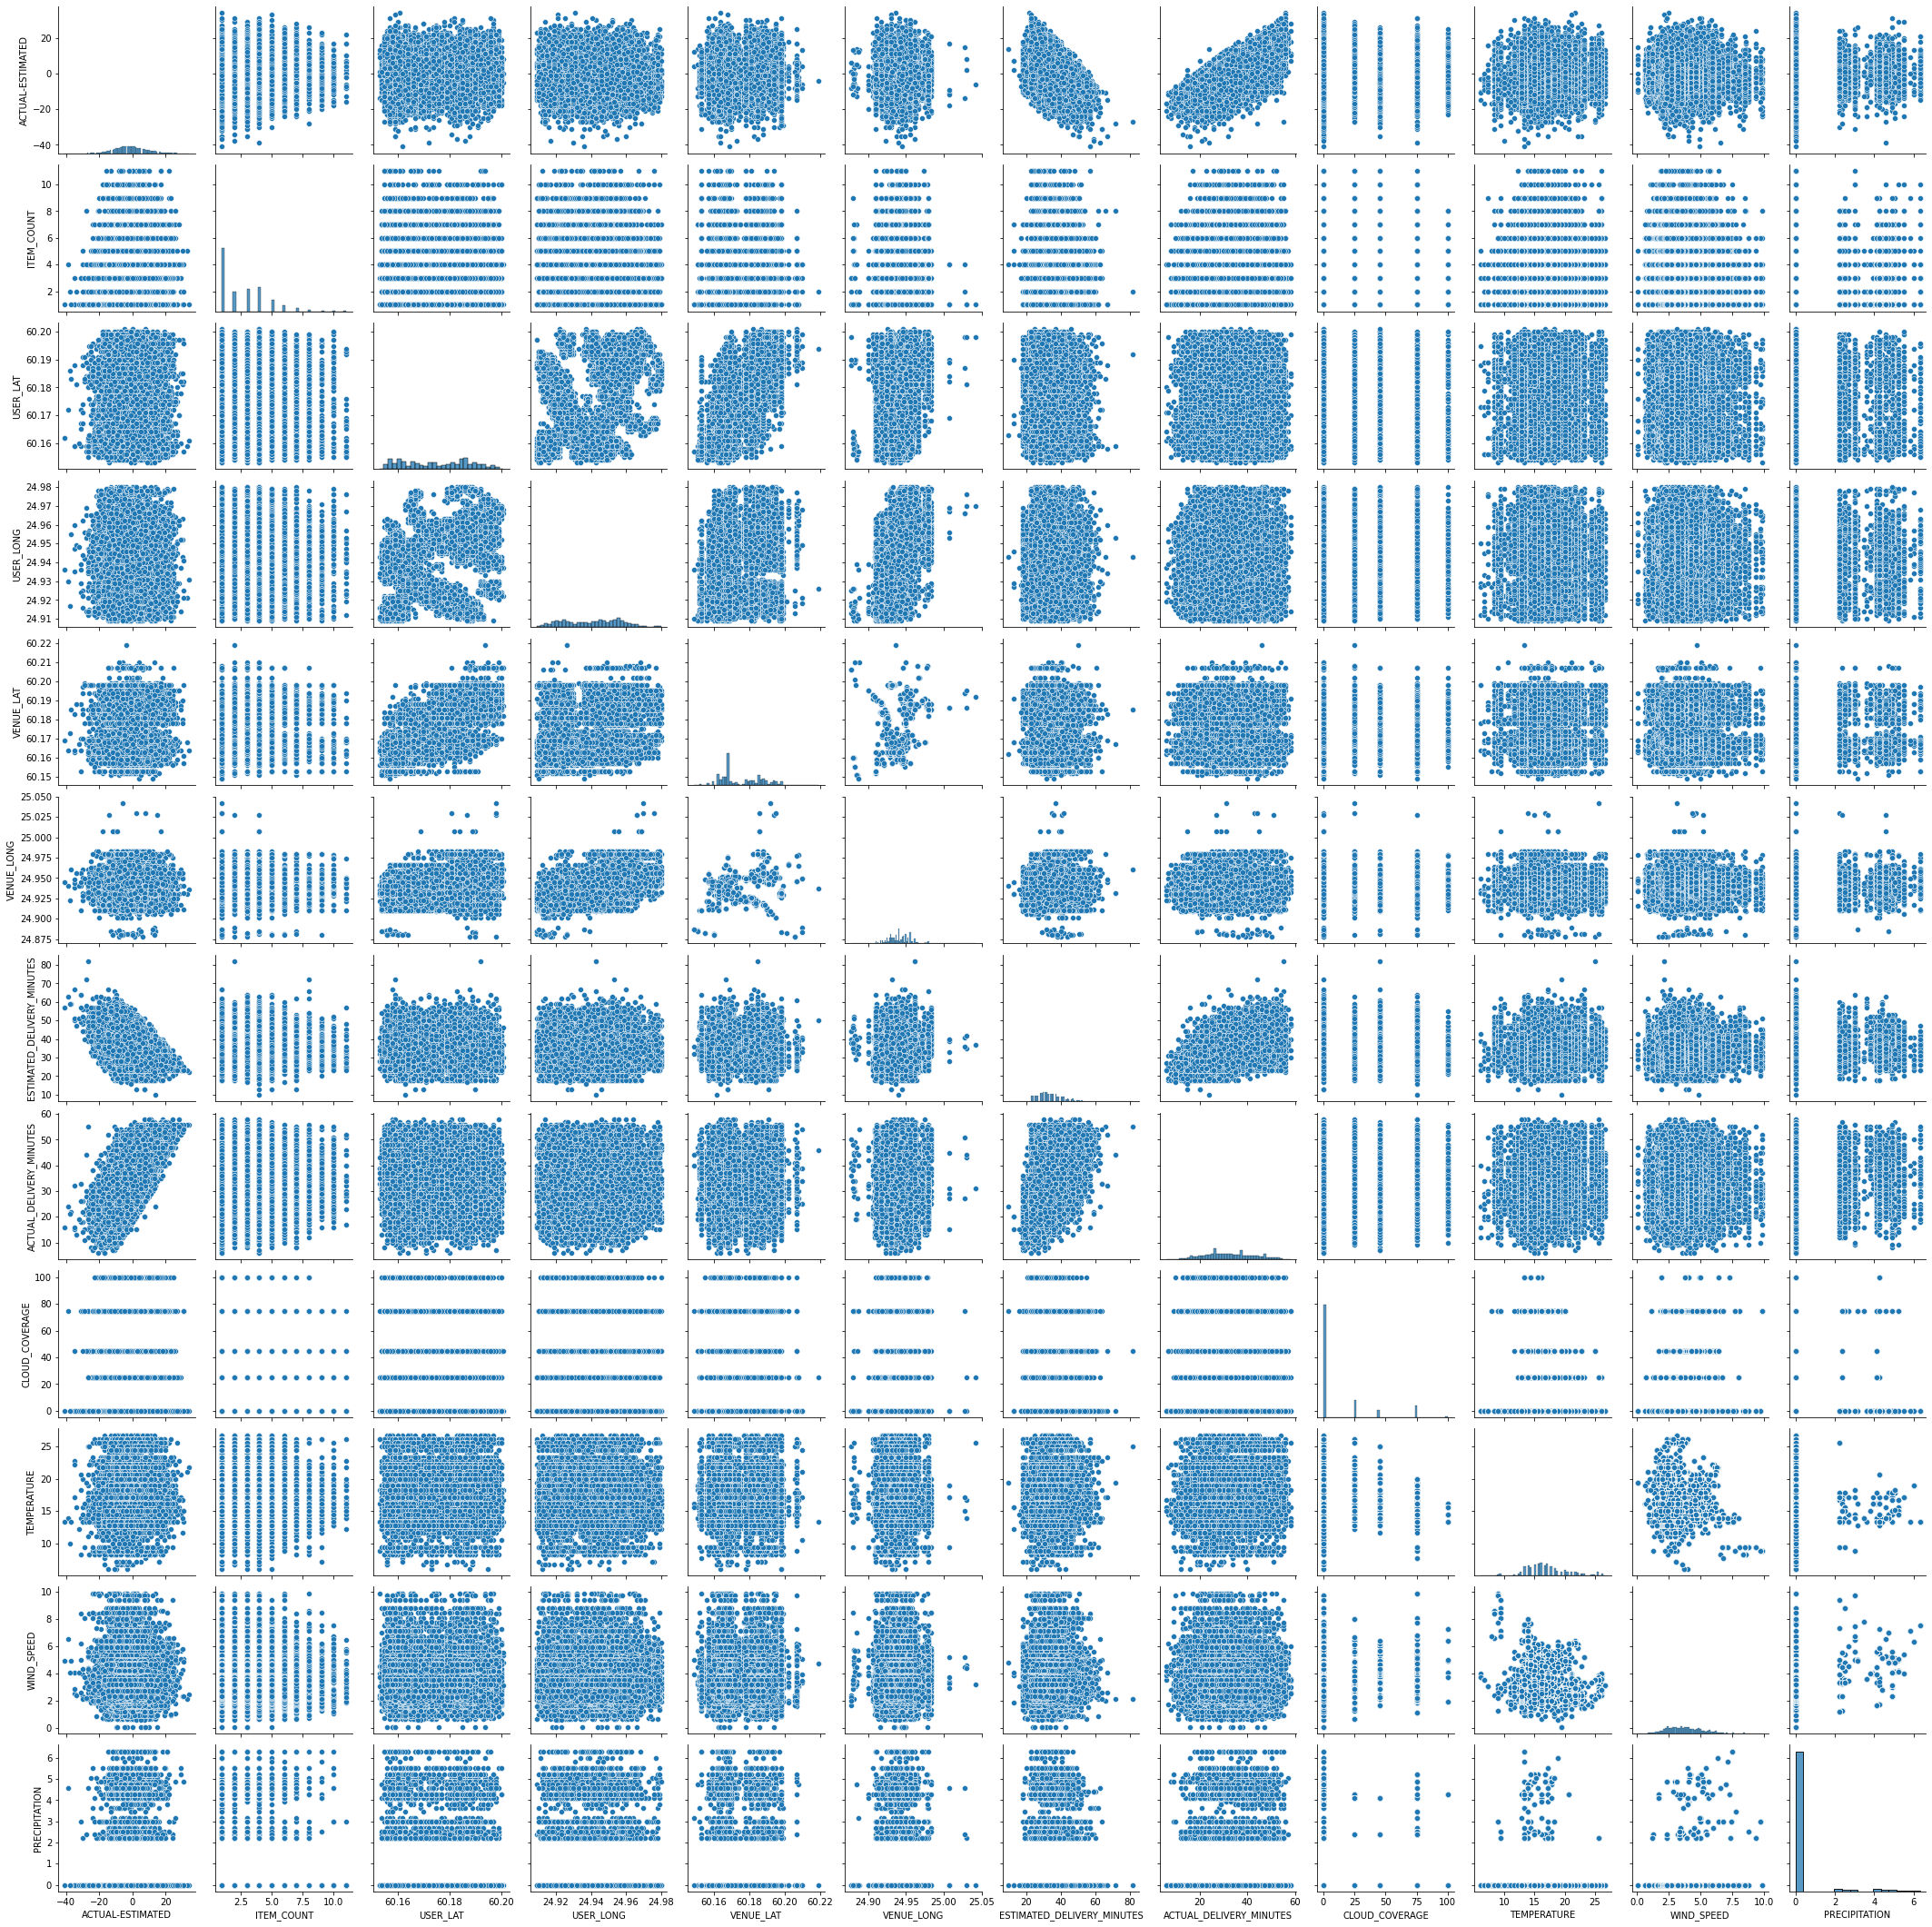

In [6]:
sns.pairplot(data=df)

### Observations
- Similarly to the heatmap, the pair-plot didn't reveal any underlying, strong relationship between the variables.
- Since both plots didn't reveal any interesting patterns, it might be useful to look for patterns in places that didn't show up in the pair-plot.

### Time Series <a name="timeseries"></a>
---
 Looking at the dataset as a timeseries will show if there are any temporal patterns.
 
An interesting variable might be number of orders over time that can give insights into user ordering patterns.
 
Number of orders is an important variable because:
1) It coincides with delivery company's business interests in ways described in the introduction.
2) Causal relationships between time and number of orders are understandable and interpretable. Same cannot be said about for example weather or user location.

Let's create a more focused dataset that would show us number of orders made each day.


In [7]:
# Creating new DataFrame with daily frequency and number of orders
daily_df = df.groupby(pd.Grouper(key='TIMESTAMP', freq='D')).size().reset_index(name='ORDERS')
daily_df.set_index('TIMESTAMP', inplace=True)
daily_df.index.freq = 'D' # To keep pandas inference in check!

print(daily_df.head())
print(daily_df.describe())

            ORDERS
TIMESTAMP         
2020-08-01     299
2020-08-02     328
2020-08-03     226
2020-08-04     228
2020-08-05     256
           ORDERS
count   61.000000
mean   306.655738
std     58.949381
min    194.000000
25%    267.000000
50%    294.000000
75%    346.000000
max    460.000000


We can see that dataset covers a timespan of 61 days and for the given period there are on average 306 orders per day.
But A picture is worth a thousand words so let's plot the time series!

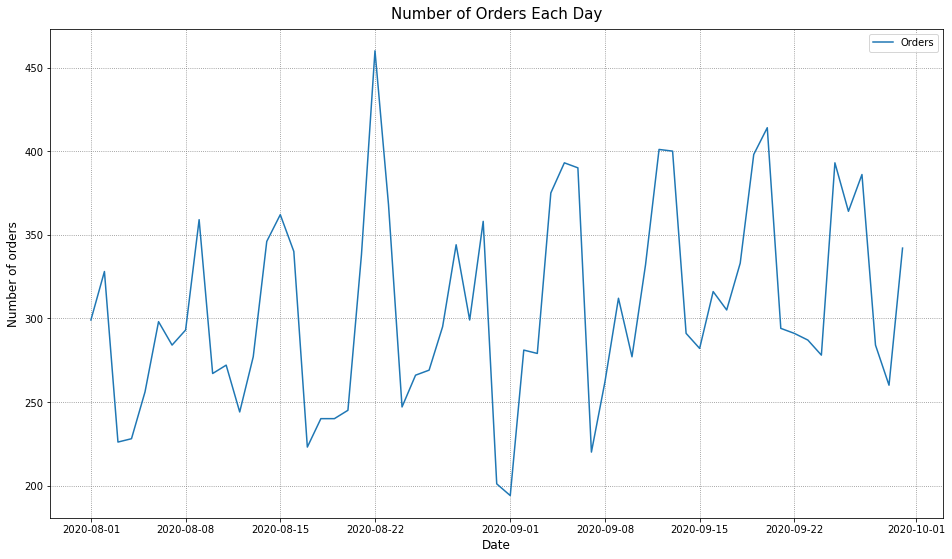

In [8]:
def orders_per_day(df: pd.DataFrame) -> None:
    """
    This function plots the number of orders per day.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
    Returns: None
    """
    
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')
    ax.plot(df.index, df['ORDERS'])

    # Labels
    ax.set_title("Number of Orders Each Day", fontsize=15, pad=10)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
        
    # Grid & Legend
    plt.grid(linestyle=":", color='grey')
    plt.legend(["Orders"])
    plt.show()
    

orders_per_day(daily_df)

### Observations
- So far there doesn't seem to be any apparent patterns in the dataset. We might need to decompose the series to see what it's really made of.
- September 1st has the deepest valley and its the only day with less than 200 orders. Might be an outlier.

In order to understand the series a little better we would need to decompose it and check for:
- Trends
- Seasonality

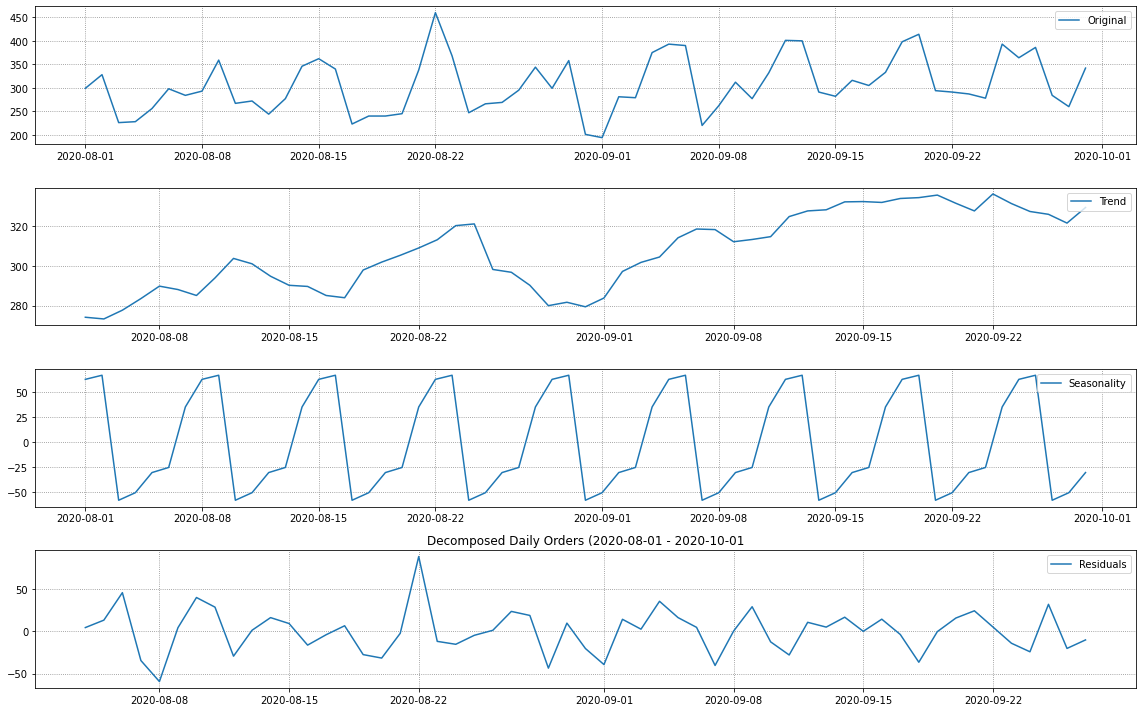

In [9]:
def decompose_series(df: pd.DataFrame) -> None:
    """
    This function decomposes the time series
    into trend, seasonality and residuals.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    # Decomposition
    decomposition = seasonal_decompose(df)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    #Figure
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(16,10), facecolor='w')

    ax1.plot(df, label='Original')
    ax2.plot(trend, label='Trend')
    ax3.plot(seasonal,label='Seasonality')
    ax4.plot(residual, label='Residuals')
    
    # Legend
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')
    ax4.legend(loc='upper right')
    
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')
    ax3.grid(linestyle=":", color='grey')
    ax4.grid(linestyle=":", color='grey')

    plt.title('Decomposed Daily Orders (2020-08-01 - 2020-10-01')
    plt.tight_layout()
    plt.show()


decompose_series(daily_df)

### Observations
- **Trend:** There is a general rising trend for the given time period. However, it is not constant. Number of orders decreases  around 9th of september but then recovers resulting in an approx. 7% overall increase for the observed time period.
- **Seasonality:** There are clear weekly seasonal patterns. Number of orders is low in the beginning of the week and grows towards the weekend.
- **Residuals:** No observable patterns left in the residuals.

These patterns are definitely of interest for our analysis. However, drawing a weekly forecast based on only 2 months of data will probably have suboptimal accuracy. Instead, we can try to find more granular patterns within the data. Looking at a higher frequency of the time series will also allow us to predict shorter time periods but with greater accuracy.

For this purpose, lets plot a heatmap with days of the week, times of the day and number of orders.

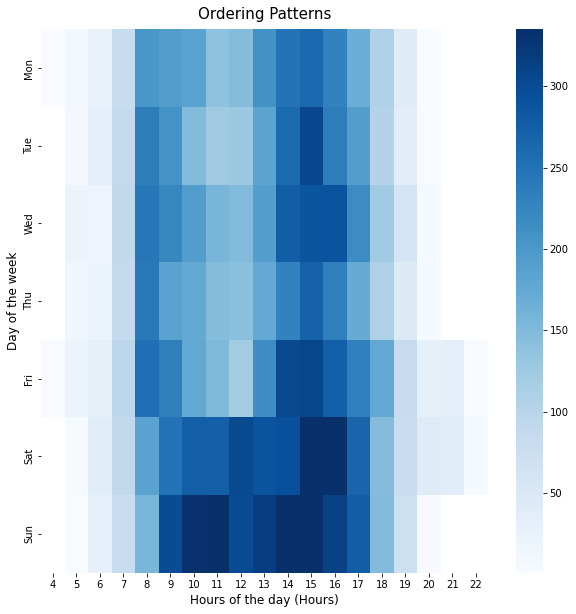

In [10]:
def orders_weekdays_hours(dataframe: pd.DataFrame) -> None:
    """
    This function plots the number of orders by weekday and hour.
    ---
    Args:
        dataframe (pd.DataFrame): Dataframe that contains the timeseries data

    Returns: None
    """
    # Data
    df = dataframe.copy(deep=False)

    # Reshaping data for the plot
    df["hour"] = pd.DatetimeIndex(df['TIMESTAMP']).hour
    df["weekday"] = pd.DatetimeIndex(df['TIMESTAMP']).weekday
    daily_activity = df.groupby(by=['weekday','hour']).count()['TIMESTAMP'].unstack()

    # Figure Object
    fig, ax = plt.subplots(figsize=(10,10), facecolor='w')
    yticklabels = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun"]
    sns.heatmap(daily_activity, robust=True, cmap="Blues", yticklabels=yticklabels)

    # Labeling
    ax.set_title("Ordering Patterns", fontsize=15, pad=10)
    ax.set_xlabel("Hours of the day (Hours)", fontsize=12, x=.5)
    ax.set_ylabel("Day of the week", fontsize=12, y=.5)
    
    plt.show()


orders_weekdays_hours(df)

### Observations
The heatmap reveals a set of interesting patterns.

- Each day seems to have two peaks in number of orders.
- Hottest ordering times are slightly different for workdays and weekends.
- During the workdays number of orders peaks at 8am and 16pm with decrease in orders during the lunchtime.
- The weekends exhibit a similar behavior but higher overall number of orders and with different peaks at 10-11am and 15-16pm.

We can investigate these patterns further by focusing on the hourly frequency of our time series.

In [11]:
# Creating new DataFrame with hourly frequency number of orders
hourly_df = df.groupby(pd.Grouper(key='TIMESTAMP', freq='1h')).size().reset_index(name='ORDERS')

hourly_df.set_index('TIMESTAMP', inplace=True)
hourly_df.index.freq = 'H'

print(hourly_df, hourly_df.describe())

                     ORDERS
TIMESTAMP                  
2020-08-01 06:00:00       3
2020-08-01 07:00:00       6
2020-08-01 08:00:00      15
2020-08-01 09:00:00      20
2020-08-01 10:00:00      26
...                     ...
2020-09-30 16:00:00      42
2020-09-30 17:00:00      26
2020-09-30 18:00:00      19
2020-09-30 19:00:00       8
2020-09-30 20:00:00       1

[1455 rows x 1 columns]             ORDERS
count  1455.000000
mean     12.856357
std      13.733086
min       0.000000
25%       0.000000
50%       8.000000
75%      24.000000
max      53.000000


Now let's plot the hourly time series!

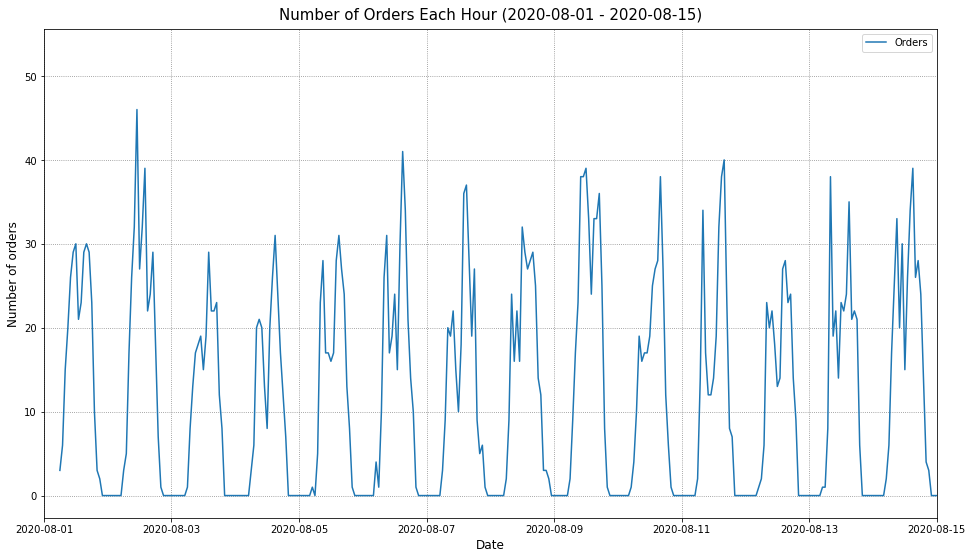

In [12]:
def orders_per_hour(df: pd.DataFrame, start: datetime, end: datetime ) -> None:
    """
    This function plots the number of orders per hour.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        start (datetime): datetime.datetime start date to plot
        end (datetime): datetime.datetime end date to plot
        
    Returns: None
    """
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')
    ax.plot(df.index, df['ORDERS'])

    # Labels
    ax.set_title(f"Number of Orders Each Hour ({start.date()} - {end.date()})", fontsize=15, pad=10)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Axis Limit
    ax.set_xlim([start, end])
    
    # Legend & Grid
    plt.grid(linestyle=":", color='grey')
    plt.legend(["Orders"])
    plt.show()
    

start = datetime(2020, 8, 1)
end = datetime(2020, 8, 15)
orders_per_hour(hourly_df, start, end)

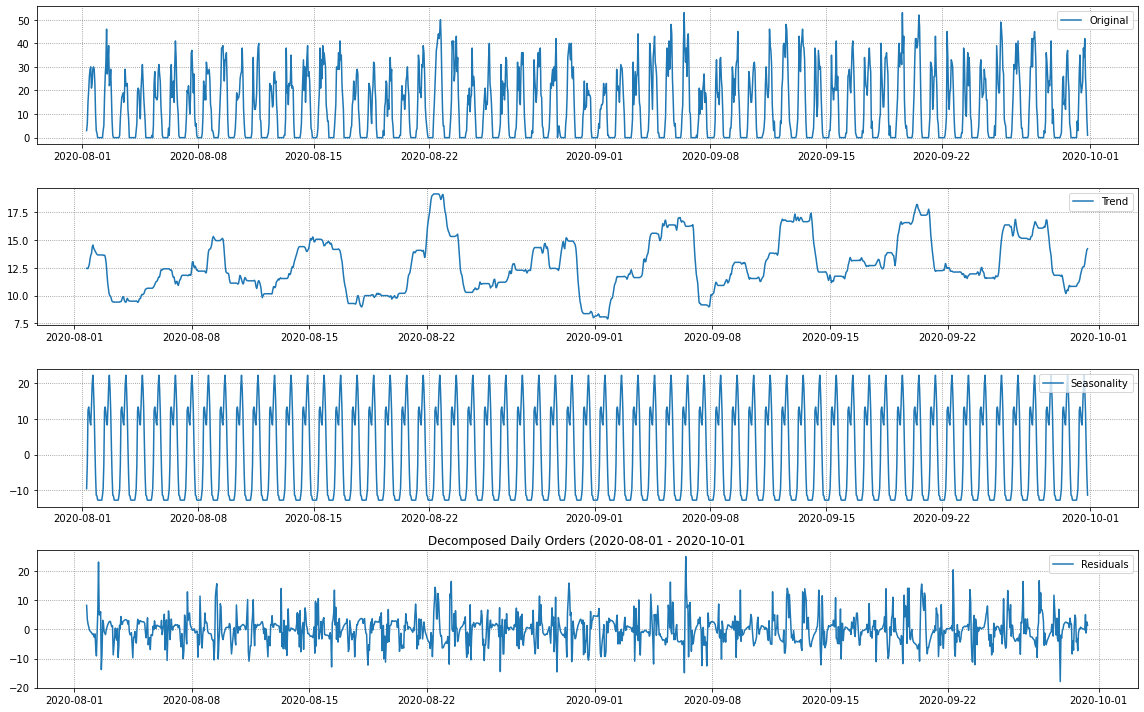

In [13]:
decompose_series(hourly_df)

### Observations:
- **Trend:** There doesn't seem to be definite upwards or downwards trend. However, we remember from daily plot that there is a trend.
- **Seasonality:** There is very strong daily seasonal pattern. And we remember from daily plot that there is also a weekly seasonalty.
- **Residuals:** No observable patterns left in the residuals.

The strong daily seasonality in the series is a pattern worth exploring because it also coincides with business interests defined in the introduction.

Let's analyze the seasonal pattern more in detail.

### Stationary Check   <a name="stationary"></a>
---
Before we try to apply any models lets check if the time series are Stationary.
Stationary comes in many flavors but here we will use the following definition: A time series is stationary if a shift in time doesn't cause a change in the shape of its distribution. As a result of this the mean, standard deviation are not time dependent.

Fluctuating rolling mean and standard deviation can be first indication of Non-stationary time series.

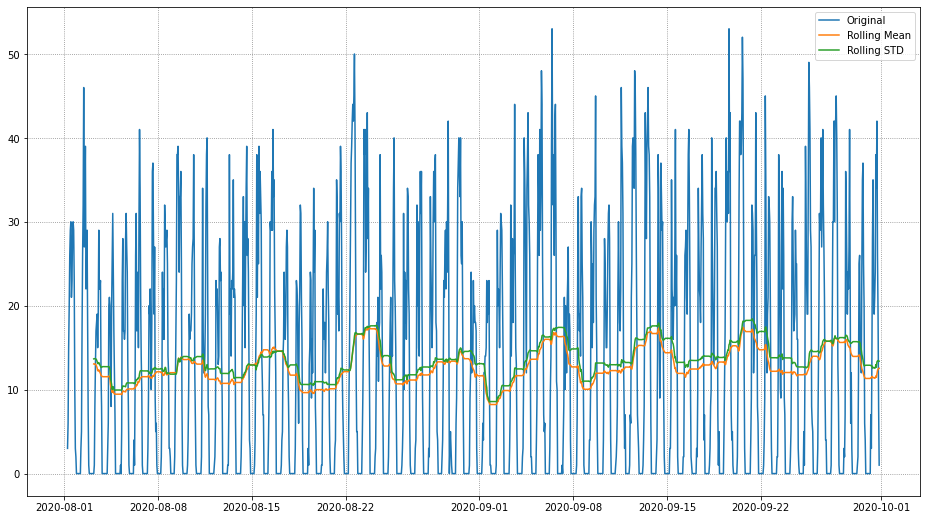

In [14]:
def plot_rolling_mean_and_std(dataframe: pd.DataFrame, window: int) -> None:
    """
    This function plots the dataframes
    rolling mean and rolling standard deviation.
    ---
    Args:
        dataframe (pd.DataFrame): Dataframe contains the timeseries
        window (int): window size
    Returns: None
    """
    df = dataframe.copy()
    # Get Things Rolling
    roll_mean = df.rolling(window=window).mean()
    roll_std = df.rolling(window=window).std()
    
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')
    ax.plot(df, label='Original')
    ax.plot(roll_mean, label='Rolling Mean')
    ax.plot(roll_std,  label='Rolling STD')
    
    # Legend & Grid
    ax.legend(loc='upper right')
    plt.grid(linestyle=":", color='grey')
    plt.show()


plot_rolling_mean_and_std(hourly_df, window=48)

### Observations
- We can see that the mean and the variance of time series are not constant over time.
- Mean and the variance seem to follow weekly seasons.

Judging from. the plot series do not look stationary. With this in mind lets perform two statistical tests to discover if series have unit root or if they are trend-stationary.

In [15]:
def perform_adf_test(df: pd.DataFrame) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
        
    Returns: None
    """
    
    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)
    
    print('\nAugmented Dickey Fuller Test')
    print('---'*15)
    print('ADF Statistic: %f' % adf_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Number of observations used: {n_observ}')
    print(f'T values corresponding to adfuller test:')
    for key, value in crit_vals.items():
        print(key, value)


def perform_kpss_test(df: pd.DataFrame) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    
    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)



In [16]:
perform_adf_test(hourly_df)
perform_kpss_test(hourly_df)


Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -3.464712
p-value: 0.008941
Number of lags used: 24
Number of observations used: 1430
T values corresponding to adfuller test:
1% -3.434931172941245
5% -2.8635632730206857
10% -2.567847177857108

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.396855
p-value: 0.078511
Number of lags used: 20
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


#### ADF & KPSS Results
- Since ADF Statistic -3.46 < -3.43 and p-value: 0.0089 < 0.05 we can reject the $N_{0}$ hypothesis in the favor of $N_{a}$
- Since KPSS Statistic 0.396 < 0.463 and 0.078 > 0.05 we fail to reject the $N_{0}$ hypothesis.

Based on these results we can conclude that:
- According to ADF test our series have no unit root
- According to KPSS test our series are trend-stationary
- This confirms our observation from the graph above where rolling mean and std are following a weekly trend.

## Modelling <a name="modelling"></a>
---
Now that we established that series are trend-stationary we can start modelling. Considering relatively small sample size, the fact that the dataset captures a seasonal time-series and the number of variables under examination, SARIMA seems like an adequate model for the task. If a simple model can predict the target variable well, then its prediction will depend on less variables and thus it will be a more general model. Therefore, for now we will not look for more complicated models that might be a better fit.

In order to choose the right ARIMA model lets plot the Autocorrelation and partial autocorrelation function plots.

### ACF & PACF
ACF and PACF will help us to identify the lags that have high correlations.

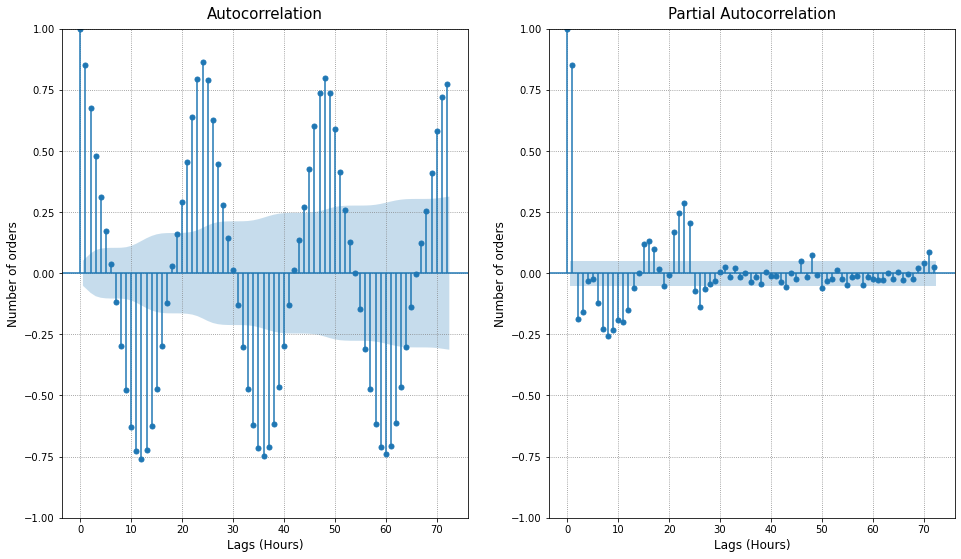

In [17]:
def plot_acf_pacf(df: pd.DataFrame, acf_lags: int, pacf_lags: int) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), facecolor='w')
    
    # ACF & PACF
    plot_acf(df['ORDERS'], ax=ax1, lags=acf_lags)
    plot_pacf(df['ORDERS'], ax=ax2, lags=pacf_lags, method='ywm')

    # Labels
    ax1.set_title("Autocorrelation", fontsize=15, pad=10)
    ax1.set_ylabel("Number of orders", fontsize=12)
    ax1.set_xlabel("Lags (Hours)", fontsize=12)

    ax2.set_title("Partial Autocorrelation", fontsize=15, pad=10)
    ax2.set_ylabel("Number of orders", fontsize=12)
    ax2.set_xlabel("Lags (Hours)", fontsize=12)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()

    
plot_acf_pacf(hourly_df, acf_lags=72, pacf_lags= 72)

#### **Observations:**
- ACF
    - As we already knew our series are seasonal and our ACF plot confirms this pattern. If we plot more lags we will also observe that significance of the lags is gradually declining.
    - First significant lag is lag 1. Which is not surprising. The number of daily orders raises/decreases gradually from hour to hour. Hence the orders during the previous hour might tell us something about orders during the current hour.
    - Netx important lags are at lag 12 and 24. These are deterministic seasonal patterns connected with day/night cycles. 12 hour lag is negatively correlated because when at 8:00am number of orders starts to increase at 20:00pm the number of orders is already decreasing. However, 24 hour lag shows that number of orders made today at 16:00pm might hint about the number of orders to be made tomorrow at 16:00pm.
- PACF
    - With PACF we can see that lag 1 and 24  have the highest correlation. This means that seasons 24 hours apart are directly correlated regardless of what is happening in between.
    
We can take a look at Lags of interest more in detail:

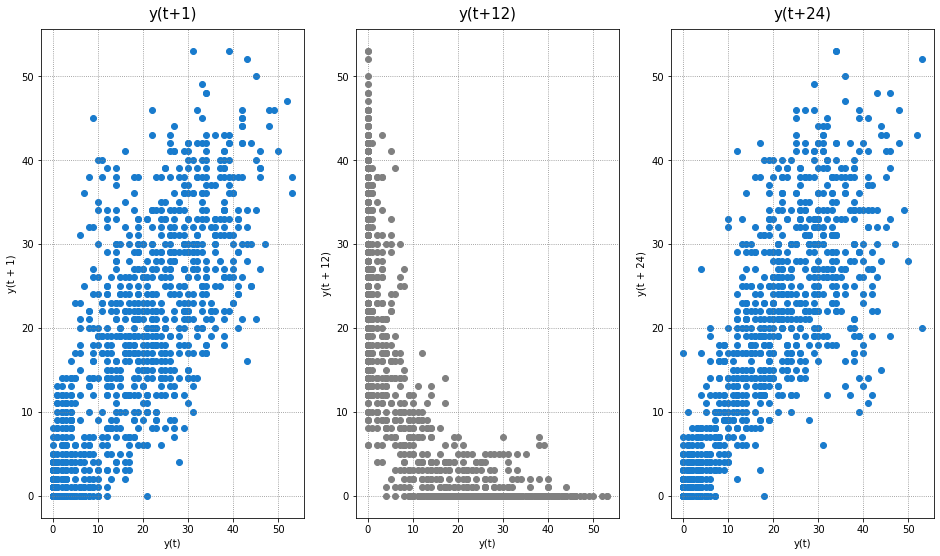

In [18]:
def lag_plots(df: pd.DataFrame) -> None:
    """
    This function plots the correlation between
    current y(t) and y(t-1), y(t-12) and y(t-24) lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains a time series
        
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9), facecolor='w')
    
    # Lags
    lag_plot(df['ORDERS'], lag=1, ax=ax1, c='#187bcd')
    lag_plot(df['ORDERS'], lag=12, ax=ax2, c='grey')
    lag_plot(df['ORDERS'], lag=24, ax=ax3, c='#187bcd')
    
    # Labels
    ax1.set_title("y(t+1)", fontsize=15, pad=10)
    ax2.set_title("y(t+12)", fontsize=15, pad=10)
    ax3.set_title("y(t+24)", fontsize=15, pad=10)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')
    ax3.grid(linestyle=":", color='grey')


lag_plots(hourly_df)

#### **Observations:**
- With lags 1, 12 and 24 we confirm the correlations shown in ACF plot. Positive linear correlations can be seen in lag 1 and lag 24 and a negative non-linear correlation in lag 12.

Armed with this information lets start forging the model!

## SARIMA  <a name="sarima"></a>
---
The SARIMA model is specified 

$$SARIMA(p, d, q) \times (P, D, Q)_s$$

Where:
- Trend Elements are:
    - p: Autoregressive order
    - d: Difference order
    - q: Moving average order
- Seasonal Elements are:
    - P: Seasonal autoregressive order.
    - D: Seasonal difference order. D=1 would calculate a first order seasonal difference
    - Q: Seasonal moving average order. Q=1 would use a first order errors in the model
    - s  Single seasonal period

### Parameter Estimation
---

We will use Box–Jenkins method for identifying parameters for SARIMA. There are of course more modern approaches like grid-search and auto.arima() but the reason I prefer starting with Box–Jenkins is that it forces you to understand your model as opposed to brute forcing your way through the parameters.
First we will try to estimate the parameters based on our theoretical understanding of ACF and PACF plots to ensure that we understand our model. Next, we will cross check our values with the results of grid search.

#### Theoretical estimates:
- **s**: In our ACF plot there is one peak and one valley every 24 hours. Thus, we can set seasonal period to **s = 24**. This also backed by our subject matter knowledge.
- **p**: We are dealing with a gradual change where $y_{t-1}$ is not drastically different from $y_{t}$ hence the trend autoregressive order will be set to **p = 1**. This is also confirmed in the ACF plot where $y_{t-1}$ is the first significant lag.
- **d**: We established that our series are trend-stationary we will set trend differencing to **d = 1**
- **q**: Based on our PACF correlations we can set **q = 1** since its the most significant lag.
- **P**: **P = 2** will allow us to use the first and second seasonally offsets (24) in the model, e.g. $t-(s \times 1) = t-(24 \times 1)$,  $t-(s \times 1) = t-(24 \times 2)$
- **D**: Since we are dealing with seasonality we can use first degree seasonal differencing **D = 1**
- **Q**: The seasonal moving average will be set to **Q = 1**. In this case the model will take into account the moving average of lag $t-(24\times1)$ and as shown in our PACF graph this lag has a significant correlation.

Here we go:

$$ SARIMA(1, 1, 1) \times (2, 1, 1)_{24} $$

Now lets train the model! 🚀

### SARIMA Train
---

#### Test & Train Split

In [19]:
def train_test_split(df: pd.DataFrame, train_set, test_set):
    """
    Splits input dataframe into test and train set with 75% / 15%.
    ---
    Args:
        df (pd.DataFrame): dataframe to split with datetime index.
        train_set (datetime.datetime): end date of the train set (inclusive)
        test_set (datetime.datetime): end date of the test set

    Returns:
        train_df (pd.DataFrame): Train Dataframe
        test_df (pd.DataFrame):  Test Dataframe
    """
    train_set = df[df.index <= train_end]
    test_set = df[df.index > train_end]
    return train_set, test_set

warnings.simplefilter('ignore', ConvergenceWarning)

train_end = datetime(2020,9,15)
test_end = datetime(2020,9,30)

train_df, test_df = train_test_split(hourly_df, train_end, test_end)

#### Fitting SARIMA 

In [20]:
# Set Hyper-parameters
p, d, q = 1, 1, 1
P, D, Q = 2, 1, 1
s = 24

# Fit SARIMA
sarima_model = SARIMAX(train_df, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit(disp=0)
print(sarima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             ORDERS   No. Observations:                 1075
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 24)   Log Likelihood               -3158.989
Date:                            Mon, 07 Feb 2022   AIC                           6329.979
Time:                                    15:29:32   BIC                           6359.718
Sample:                                08-01-2020   HQIC                          6341.255
                                     - 09-15-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3728      0.027     13.717      0.000       0.320       0.426
ma.L1         -0.9414      0.012   

To determine the goodness of fit of the model, we can examine the residuals and expect them be normally distributed around 0.


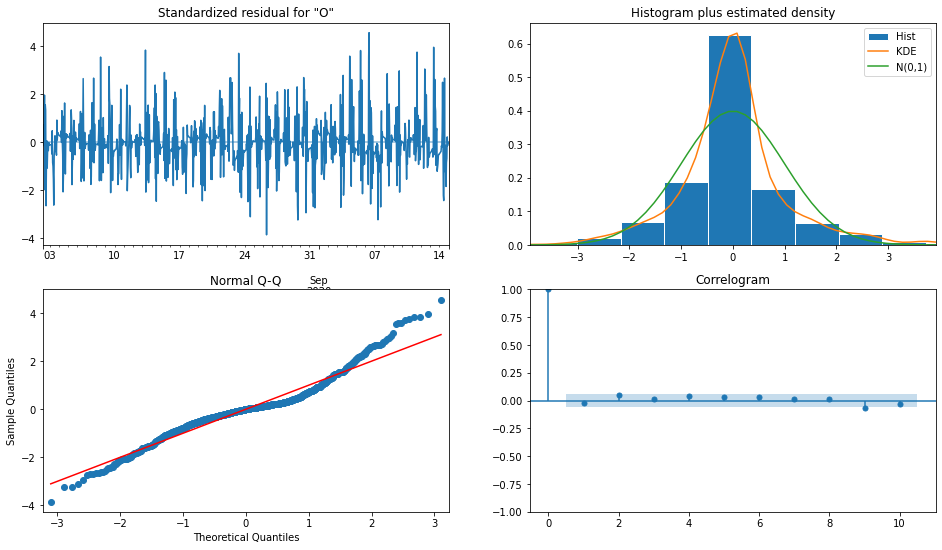

In [21]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(16, 9))
plt.show()

#### Observations:
- **The standardize residual plot:**  The residuals over time don’t display any obvious patterns. They appear as white noise.
- **The Normal Q-Q-plot:** Shows that the ordered distribution of residuals follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). However, the slight curving indicates that our distribution has heavier tails.
- **Histogram and estimated density plot:**  The KDE follows the N(0,1) line however with noticeable differences. As mentioned before our distribution has heavier tails.
- **The Correlogram plot:** Shows that the time series residuals have low correlation with lagged versions of itself. Meaning there are no patterns left to extract in the residuals.

Lets test the model on our training set:

### SARIMA Test <a name="sarima_train"></a>
---

In [22]:
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarima_predictions = sarima_model_fit.predict(start=pred_start_date, end=pred_end_date)
sarima_residuals = test_df['ORDERS'] - sarima_predictions

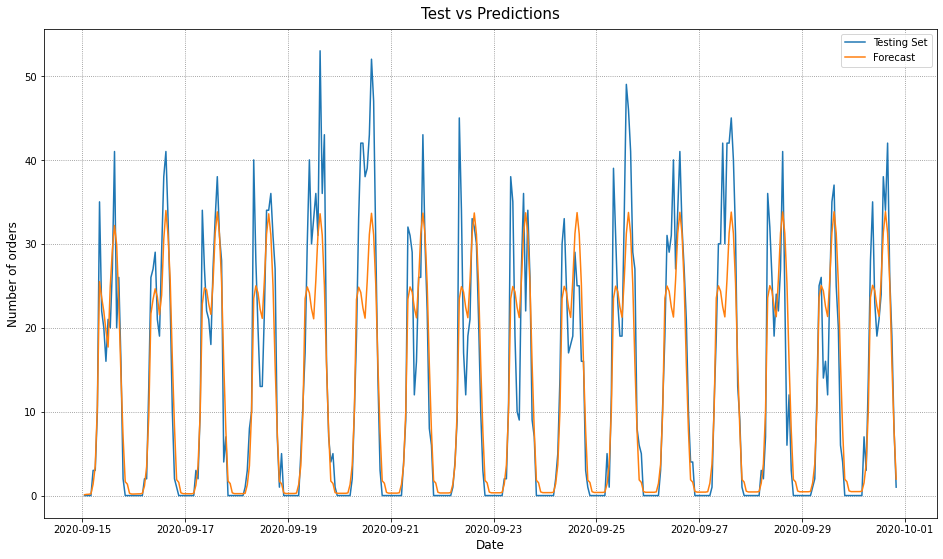

In [23]:
def plot_test_predictions(test_df: pd.DataFrame, predictions) -> None:
    """
    This functions plots test set vs predicted values.
    ---
    Args:
        test_df (pd:DataFrame): 
        predictions (predictions): 
    
    Returns: None
    """
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    ax.plot(test_df, label='Testing Set')
    ax.plot(predictions, label='Forecast')

    # Labels
    ax.set_title("Test vs Predictions", fontsize=15, pad=10)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()

plot_test_predictions(test_df, sarima_predictions)

### SARIMA Evaluation

In [24]:
# Get evaluation data
sarima_aic = sarima_model_fit.aic
sarima_bic = sarima_model_fit.bic
sarima_mean_squared_error = sarima_model_fit.mse
sarima_sum_squared_error=sarima_model_fit.sse
sarima_root_mean_squared_error = np.sqrt(np.mean(sarima_residuals**2))

print(f'Akaike information criterion | AIC: {sarima_aic}')
print(f'Bayesian information criterion | BIC: {sarima_bic}')
print(f'Mean Squared Error | MSE: {sarima_mean_squared_error}')
print(f'Sum Squared Error | SSE: {sarima_sum_squared_error}')
print(f'Root Mean Squared Error | RMSE: {sarima_root_mean_squared_error}')

Akaike information criterion | AIC: 6329.978814263322
Bayesian information criterion | BIC: 6359.718086922232
Mean Squared Error | MSE: 23.867995536690096
Sum Squared Error | SSE: 25658.095201941855
Root Mean Squared Error | RMSE: 5.672003697610716


In itself these values don't say too much on their own. They are more meaningful in comparison. We will use them later to compare the models. What we can see now from the graph is that our model fits the data and captures the major underlying patterns.
RMSE of 6 doesn't sound great when we are looking at hourly target variable but it's a good starting point for the baseline model.

### SARIMA Forecast  <a name="sarima_forecast"></a>

In [25]:
# Forecast Window
days = 24
hours = days * 24

sarima_forecast = sarima_model_fit.forecast(hours)
sarima_forecast_series = pd.Series(sarima_forecast, index=sarima_forecast.index)

# Since negative orders are not possible we can trim them.
sarima_forecast_series[sarima_forecast_series < 0] = 0

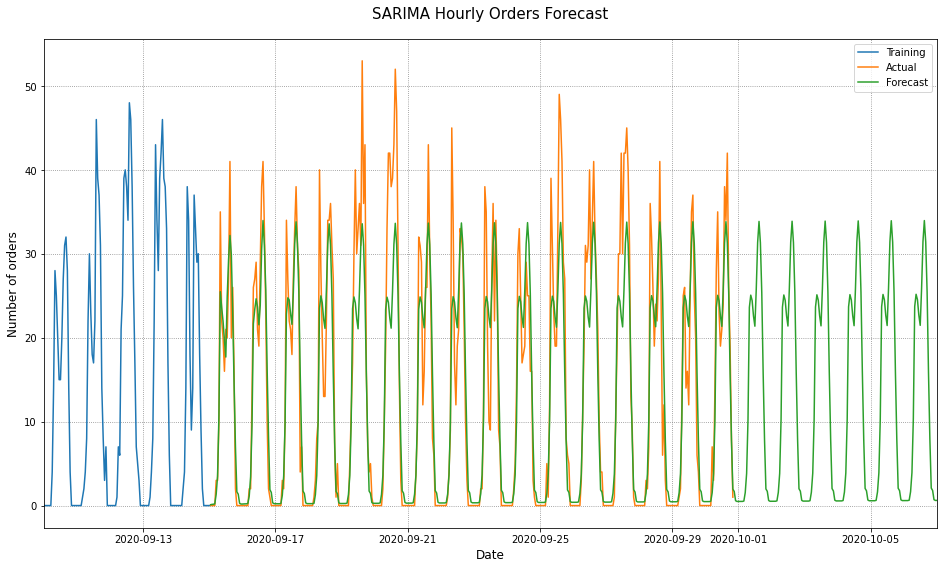

In [26]:
def plot_sarima_forecast(train_df: pd.DataFrame, test_df: pd.DataFrame, fc_series: pd.Series) -> None:
    """
    This function plots the train, test and forecast values.
    ---
    Args:
        train_df (pd.DataFrame):  training set dataframe
        test_df (pd.DataFrame):  test set dataframe
        fc_series (pd.Series):  forecast values as series
        
    Returns: None
    """
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    # Plot Train, Test and Forecast.
    ax.plot(train_df['ORDERS'], label='Training')
    ax.plot(test_df['ORDERS'], label='Actual')
    ax.plot(fc_series, label='Forecast')

    # Labels
    ax.set_title("SARIMA Hourly Orders Forecast", fontsize=15, pad=20)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)

    xmin = datetime(2020, 9, 10)
    xmax = datetime(2020, 10, 7)
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    
    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()
    
plot_sarima_forecast(train_df, test_df, sarima_forecast_series)

### Observations
- Our SARIMA model predicts the overall hourly ordering patterns pretty well. It captures the two daily peaks and the lunchtime valley between them.
- However, it fails to predict weekly patterns. Every day in our forecast seem to be the same. If this model was sent to production we would be able to predict the number of orders every hour but that prediction would be based on the assumption that the number of orders is the same every day.
- While this model doesn't have a great long term predictive power it can serve as a solid baseline for our next models.


## SARIMAX <a name="sarimax"></a>  <a name="sarimax"></a>
---

Since our previous model failed to capture the differences between weekdays. This time we will use SARIMAX model and add one exogenous variable that would represent the weekday.
Let's make a new dataframe that would include both orders and day of the week as features.

#### Feature Engineering

In [27]:
hour_weekday_df = hourly_df.copy()
hour_weekday_df['weekday_exog'] = hour_weekday_df.index.weekday
print(hour_weekday_df.head(10))

                     ORDERS  weekday_exog
TIMESTAMP                                
2020-08-01 06:00:00       3             5
2020-08-01 07:00:00       6             5
2020-08-01 08:00:00      15             5
2020-08-01 09:00:00      20             5
2020-08-01 10:00:00      26             5
2020-08-01 11:00:00      29             5
2020-08-01 12:00:00      30             5
2020-08-01 13:00:00      21             5
2020-08-01 14:00:00      23             5
2020-08-01 15:00:00      29             5


Based on the mean number of sales made on each weekday we can create dummy variables that mimic the daily differences.


In [28]:
weekday_exog = hour_weekday_df[(hour_weekday_df != 0).all(1)]
weekday_exog = weekday_exog.groupby(weekday_exog.index.weekday)['ORDERS'].mean()
print(weekday_exog.head(7))

TIMESTAMP
1    17.386364
2    18.591241
3    18.628099
4    19.891304
5    21.939597
6    25.715385
Name: ORDERS, dtype: float64


These are the mean number of sales each weekday (1=Monday). We will use them to create our dummy variables.

In [29]:
weekday_exog = {key: (weekday_exog[key] / weekday_exog[1]) for key in weekday_exog.keys()}
print(weekday_exog)

{1: 1.0, 2: 1.0693001288106483, 3: 1.0714200831847889, 4: 1.144075021312873, 5: 1.2618853357897968, 6: 1.4790548014077425}


In [30]:
hour_weekday_df.replace({"weekday_exog": weekday_exog})

ORDERS  weekday_exog
TIMESTAMP                                
2020-08-01 06:00:00       3      1.261885
2020-08-01 07:00:00       6      1.261885
2020-08-01 08:00:00      15      1.261885
2020-08-01 09:00:00      20      1.261885
2020-08-01 10:00:00      26      1.261885
...                     ...           ...
2020-09-30 16:00:00      42      1.069300
2020-09-30 17:00:00      26      1.069300
2020-09-30 18:00:00      19      1.069300
2020-09-30 19:00:00       8      1.069300
2020-09-30 20:00:00       1      1.069300

[1455 rows x 2 columns]

### Parameter Estimation
---
Last time we used our theoretical understanding to estimate the Hyper-parameters. This time we will use Grid search to see how each model performs and evaluate them based on their MSE. This does not mean that we are throwing away our theoretical values. We will still use them to estimate the ranges for grid search.

In [31]:
p = range(1, 3)
d = range(1, 2)
q = range(1, 3)
s = 24

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]

def grid_search_sarimax(train_set: pd.DataFrame) -> None:
    """
    This function perform a grid search for SARIMAX model Hyper-Parameters.
    ---
    Args:
        train_set (pd.DataFrame): Training set for grid search.
        
    Returns: None
    """
    
    # Supress UserWarnings
    warnings.simplefilter('ignore', category=UserWarning)
    
    # Grid Search
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            model = SARIMAX(train_set['ORDERS'],
                            order=order,
                            seasonal_order=seasonal_order,
                            exog=train_set['weekday_exog']
                            )
            results = model.fit(disp=0)
            print(f'ARIMA{order}x{seasonal_order} -> AIC: {results.aic}, BIC:{results.bic},  MSE: {results.mse}')

# Function call commented for performance reasons
# You can find the output below

#grid_search_sarimax(train_df)

#### SARIMAX Grid Search Results

---

- ARIMA(1, 1, 1)x(1, 1, 1, 24) -> AIC: 6299.4939326908, BIC:6329.233205349709,  MSE: 23.24679302410412
- ARIMA(1, 1, 1)x(1, 1, 2, 24) -> AIC: 6294.48430145507, BIC:6329.180119557131,  MSE: 23.082991711862206
- ARIMA(1, 1, 1)x(2, 1, 1, 24) -> AIC: 6285.9166550495, BIC:6320.612473151561,  MSE: 22.8785869931469
- ARIMA(1, 1, 1)x(2, 1, 2, 24) -> AIC: 6256.2474375954935, BIC:6295.899801140706,  MSE: 22.166160006884336
- ARIMA(1, 1, 2)x(1, 1, 1, 24) -> AIC: 6298.9033703076, BIC:6333.599188409661,  MSE: 23.192918094737994
- ARIMA(1, 1, 2)x(1, 1, 2, 24) -> AIC: 6293.551778092962, BIC:6333.204141638174,  MSE: 23.0224542602018
- ARIMA(1, 1, 2)x(2, 1, 1, 24) -> AIC: 6284.75105539027, BIC:6324.4034189354825,  MSE: 22.814803156287404
- ARIMA(1, 1, 2)x(2, 1, 2, 24) -> AIC: 6254.90413501809, BIC:6299.513044006454,  MSE: 22.106947769139186  ⬅️  Winner 🎉
- ARIMA(2, 1, 1)x(1, 1, 1, 24) -> AIC: 6298.907070842673, BIC:6333.602888944734,  MSE: 23.194366620934346
- ARIMA(2, 1, 1)x(1, 1, 2, 24) -> AIC: 6293.509521307804, BIC:6333.161884853016,  MSE: 23.023087416633086
- ARIMA(2, 1, 1)x(2, 1, 1, 24) -> AIC: 6284.710372773889, BIC:6324.362736319101,  MSE: 22.815815134130453
- ARIMA(2, 1, 1)x(2, 1, 2, 24) -> AIC: 6254.888355043596, BIC:6299.49726403196,  MSE: 22.108790086374118
- ARIMA(2, 1, 2)x(1, 1, 1, 24) -> AIC: 6300.964055610373, BIC:6340.616419155585,  MSE: 23.19764611240351
- ARIMA(2, 1, 2)x(1, 1, 2, 24) -> AIC: 6295.689711807575, BIC:6340.298620795939,  MSE: 23.03154456682537
- ARIMA(2, 1, 2)x(2, 1, 1, 24) -> AIC: 6286.780741113156, BIC:6331.389650101521,  MSE: 22.82234155482618
- ARIMA(2, 1, 2)x(2, 1, 2, 24) -> AIC: 6260.656207248098, BIC:6310.221661679614,  MSE: 22.174750318651217

From the output we can see that **ARIMA(1, 1, 2)x(2, 1, 2, 24)** comes out as the winner with lowest MSE value.
However, does it still align with our theoretical understanding? Well its not too far from our initial estimates: **ARIMA(1, 1, 1)x(2, 1, 1, 24)**. Seems like if we would have been a little more aggressive with our q & Q parameters we would pick the lowest MSE.
Now based on these hyper parameters lets train the model again.

### SARIMAX Train
---

#### Test & Train Split 

In [32]:
train_end = datetime(2020,9,15)
test_end = datetime(2020,9,30)
train_df, test_df = train_test_split(hour_weekday_df, train_end, test_end) 

In [33]:
# Set Hyper-Parameters
p, d, q = 1, 1, 2
P, D, Q = 2, 1, 2
s = 24
exog = train_df['weekday_exog']

# Fit SARIMAX
sarimax_model = SARIMAX(train_df['ORDERS'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                exog=exog)

sarimax_model_fit = sarimax_model.fit(disp=0)

# Summary
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             ORDERS   No. Observations:                 1075
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 24)   Log Likelihood               -3118.452
Date:                            Mon, 07 Feb 2022   AIC                           6254.904
Time:                                    15:31:00   BIC                           6299.513
Sample:                                08-01-2020   HQIC                          6271.818
                                     - 09-15-2020                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
weekday_exog     0.8400      0.138      6.073      0.000       0.569       1.111
ar.L1            0.4937      

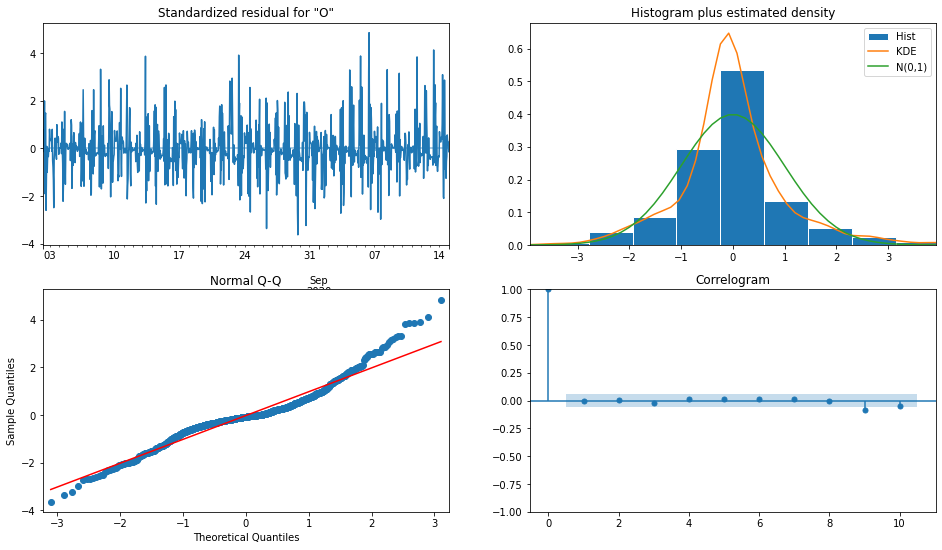

In [34]:
#Plot diagnostics
sarimax_model_fit.plot_diagnostics(figsize=(16, 9))
plt.show()

#### Observations:
- **The standardize residual plot:**  The residuals over time don’t display any obvious patterns. They appear as white noise.
- **The Normal Q-Q-plot:** Shows that the ordered distribution of residuals follows the linear trend.
- **Histogram and estimated density plot:**  The KDE follows the N(0,1) line however with slight differences.
- **The Correlogram plot:** Shows that the time series residuals have low correlation with lagged versions of itself. Thus, there are no patterns left to extract in the residuals.

### SARIMAX Test   <a name="sarimax_test"></a>
---

In [35]:
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

exog = test_df['weekday_exog']
predictions = sarimax_model_fit.predict(start=pred_start_date, end=pred_end_date, exog=exog)
residuals = test_df['ORDERS'] - predictions

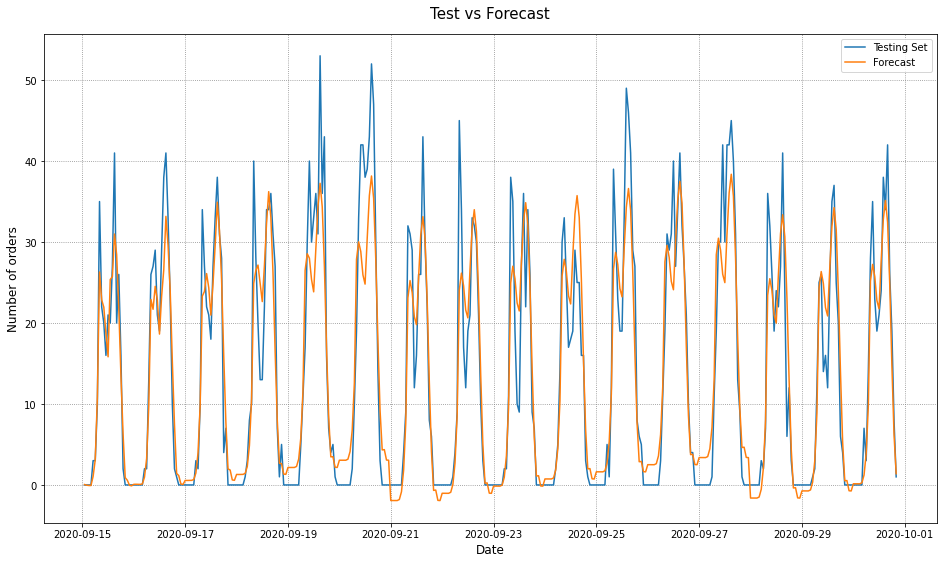

In [36]:
def plot_sarimax_test(test_set: pd.DataFrame, predictions: pd.Series) -> None:
    """
    This function plots the train set and  the forecast.
    ---
    Args:
        test_set (pd.DataFrame):  test set dataframe
        predictions (pd.Series):  forecast values as series
        
    Returns: None
    """
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    ax.plot(test_set['ORDERS'], label='Testing Set')
    ax.plot(predictions, label='Forecast')

    # Labels
    ax.set_title("Test vs Forecast", fontsize=15, pad=15)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()

    
plot_sarimax_test(test_df, predictions)

### SARIMAX Evaluation

In [37]:
# Get evaluation data
sarimax_aic = sarimax_model_fit.aic
sarimax_bic = sarimax_model_fit.bic
sarimax_mean_squared_error = sarimax_model_fit.mse
sarimax_sum_squared_error=sarimax_model_fit.sse
sarimax_root_mean_squared_error = np.sqrt(np.mean(residuals**2))

print(f'Akaike information criterion | AIC: {sarimax_aic}')
print(f'Bayesian information criterion | BIC: {sarimax_bic}')
print(f'Mean Squared Error | MSE: {sarimax_mean_squared_error}')
print(f'Sum Squared Error | SSE: {sarimax_sum_squared_error}')
print(f'Root Mean Squared Error | RMSE: {sarimax_root_mean_squared_error}')

Akaike information criterion | AIC: 6254.90413501809
Bayesian information criterion | BIC: 6299.513044006454
Mean Squared Error | MSE: 22.106947769139186
Sum Squared Error | SSE: 23764.968851824626
Root Mean Squared Error | RMSE: 5.132799959869062


This time we managed to lower our MSE to 5. Its not a huge difference but our data is hourly so in the long run this is small difference can accumulate into a big one.

## SARIMAX Forecast  <a name="sarimax_forecast"></a>
---

In [38]:
# Forecast Window
days = 24
hours = (days * 24)+1
exog = pd.date_range(start='2020-10-01', end='2020-10-25', freq='1H')

fc = sarimax_model_fit.forecast(hours, exog=exog.weekday)
fc_series = pd.Series(fc, index=fc.index)

# Since negative orders are not possible we can trim them.
fc_series[fc_series < 0] = 0

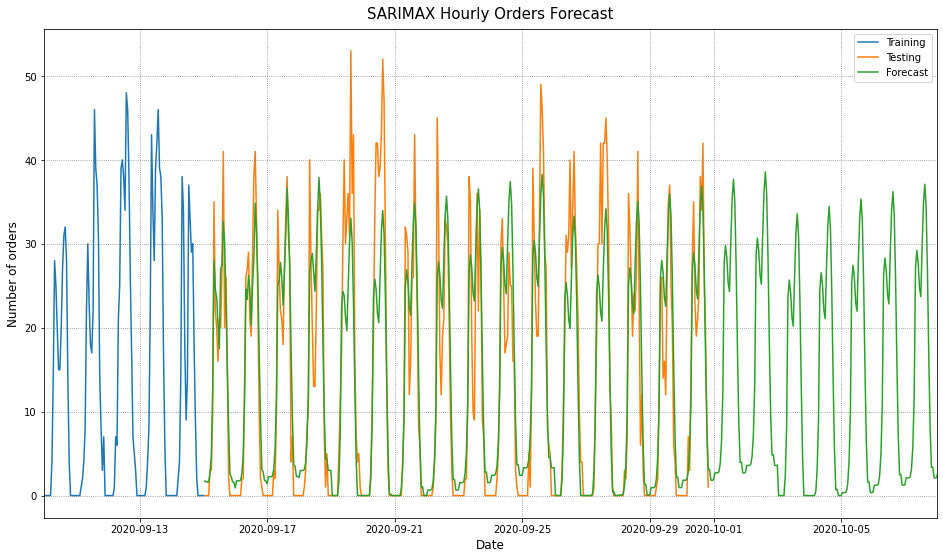

In [39]:
def plot_sarimax_forecast(train_df: pd.DataFrame, test_df: pd.DataFrame, fc_series: pd.Series) -> None:
    """
    This function plots the train set, test set and  the forecast.
    ---
    Args:
        train_df (pd.DataFrame):  training set dataframe
        test_df (pd.DataFrame):  test set dataframe
        fc_series (pd.Series):  forecast values as series
        
    Returns: None
    """
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    # Plot Train, Test and Forecast.
    ax.plot(train_df['ORDERS'], label='Training')
    ax.plot(test_df['ORDERS'], label='Testing')
    ax.plot(fc_series, label='Forecast')

    # Labels
    ax.set_title("SARIMAX Hourly Orders Forecast", fontsize=15, pad=10)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Axis Limits
    xmin = datetime(2020, 9, 10)
    xmax = datetime(2020, 10, 8)
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])

    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()


plot_sarimax_forecast(train_df, test_df, fc_series)

## Conclusion <a name="conclusion"></a>
---
In this notebook we explored the provided dataset and implemented two models:
- **SARIMA:** Model succeeded in capturing the underlying hourly ordering patterns with limited accuracy. However, it failed to capture patterns related to days of the week.
- **SARIMAX:** Model did a better job! It improved the accuracy of the previous model. However, its accuracy is still limited. This model captured the two daily spikes but not when these spikes crossed the mark of 40 orders. Additionally the model predicts orders during the night hours that are very unlikely to occur. It seems that the model would benefit from another exog variable that would apply hourly weights for each hour of the day.


In [40]:
model_comparison = pd.DataFrame({'Model':['SARIMA(1, 1, 1)(2, 1, 1)24','SARIMAX(1, 1, 2)(2, 1, 2)24'],
           'AIC':[sarima_aic, sarimax_aic],
           'BIC':[sarima_bic, sarimax_bic],
           'MSE': [sarima_mean_squared_error, sarimax_mean_squared_error],
           'SSE': [sarima_sum_squared_error, sarimax_sum_squared_error],
           'RMSE': [sarima_root_mean_squared_error, sarimax_root_mean_squared_error]})

model_comparison.head()

Model          AIC          BIC        MSE  \
0   SARIMA(1, 1, 1)(2, 1, 1)24  6329.978814  6359.718087  23.867996   
1  SARIMAX(1, 1, 2)(2, 1, 2)24  6254.904135  6299.513044  22.106948   

            SSE      RMSE  
0  25658.095202  5.672004  
1  23764.968852  5.132800

We can see that our second model minimized RMSE down to 5.1 orders.
Clearly the model is not production ready but if it had access to production level data it might perform significantly better.
In fact both models would benefit greatly from more data and perhaps the difference between them will become greater with availability of data.

### Further development.
---

There are multiple directions we can move from here. If we stick with current SARIMAX model we could:
- We can account for public holidays and other anomalies. 
- We can incorporate monthly and seasonal(summer/winder) trends.
- Data can be be spatialized and the models can be applied on a more granular level i.e. neighborhood, restaurant, user category.

Naturally all will require more data and features. However, if new data and features are added they should be in some form of interpretable causal relationships with the target variable. We had more data in our sample dataset but it did not seem to be directly applicable because establishing the causal relationships  between these variables would not have been possible.

Alternatively we can try to apply different models.
One candidate could be Exponential smoothing, although it will struggle with multi seasonal dataset like this.
If we had more data available we could apply XGboost or even dive into the rabbit hole of neural networks. But these topics are a discussion another time :)

### Thank you!